In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [4]:
# Change...
pair = 'BTCUSDT'

# interval used to compute indicators and backtest analysis
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
strategy_interval = '1H'

# date to start/end analysis
# Use '' for not to limit the data
dt_start_analysis = '2021-8-1'
dt_end_analysis = ''


In [5]:
from binance_utils import init
from trade_utils import get_data

client = init()
data = get_data(client, pair, strategy_interval)

In [6]:
data.shape

(35386, 5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35386 entries, 2017-08-17 04:00:00 to 2021-09-04 20:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OpenPrice   35386 non-null  float64
 1   HighPrice   35386 non-null  float64
 2   LowPrice    35386 non-null  float64
 3   ClosePrice  35386 non-null  float64
 4   Volume      35386 non-null  float64
dtypes: float64(5)
memory usage: 1.6 MB


In [8]:
data.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807


In [9]:
data.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-09-04 16:00:00,49873.52,50043.49,49710.24,49814.48,1460.22614
2021-09-04 17:00:00,49814.48,49966.68,49370.00,49954.83,2856.32334
2021-09-04 18:00:00,49954.84,50025.00,49844.25,49879.01,1450.72215
2021-09-04 19:00:00,49879.02,49988.66,49624.12,49974.82,1333.59578
2021-09-04 20:00:00,49974.83,50230.18,49952.84,50156.65,1301.18976


In [10]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2018-10-31 11:00:00,6339.20,6342.98,6329.74,6331.87,353.288639
2019-08-02 15:00:00,10588.47,10643.56,10545.00,10612.14,2542.132004
2018-08-26 23:00:00,6690.99,6725.00,6677.99,6700.00,547.408983
2021-08-20 07:00:00,47172.04,47199.42,46700.24,46833.48,2250.388746
2021-04-12 23:00:00,60044.75,60100.00,59859.06,59860.00,1798.601561
2020-09-01 00:00:00,11649.51,11668.50,11515.00,11612.21,4218.966566
2018-01-17 15:00:00,9160.03,9525.01,9037.94,9227.47,4904.359092
2018-05-20 08:00:00,8263.03,8305.21,8252.50,8289.01,500.115147
2019-11-08 02:00:00,9223.01,9257.47,9215.47,9237.68,903.921749


In [11]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate returns
data['Returns'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous price
data['Returns2'] = data['ClosePrice'].pct_change(2) * 100 # change from 2 previous price
data['Returns5'] = data['ClosePrice'].pct_change(5) * 100 # change from 5 previous price

# Volatility
data['volatility'] = data.rolling(24, min_periods = 24)['Returns'].std() * 100

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data.ClosePrice)

# RSI
data['RSI'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [12]:
#limit data to plot
if dt_end_analysis == '' and dt_start_analysis != '':
    data = data[dt_start_analysis:]
elif dt_end_analysis != '' and dt_start_analysis == '':
    data = data[:dt_end_analysis]
elif dt_end_analysis != '' and dt_start_analysis != '':
    data = data[dt_start_analysis:dt_end_analysis]

In [13]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

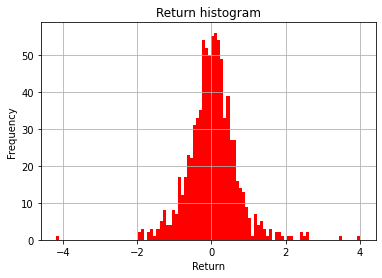

In [14]:
# Plot the histogram
data['Returns'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.title('Return histogram')
plt.show()

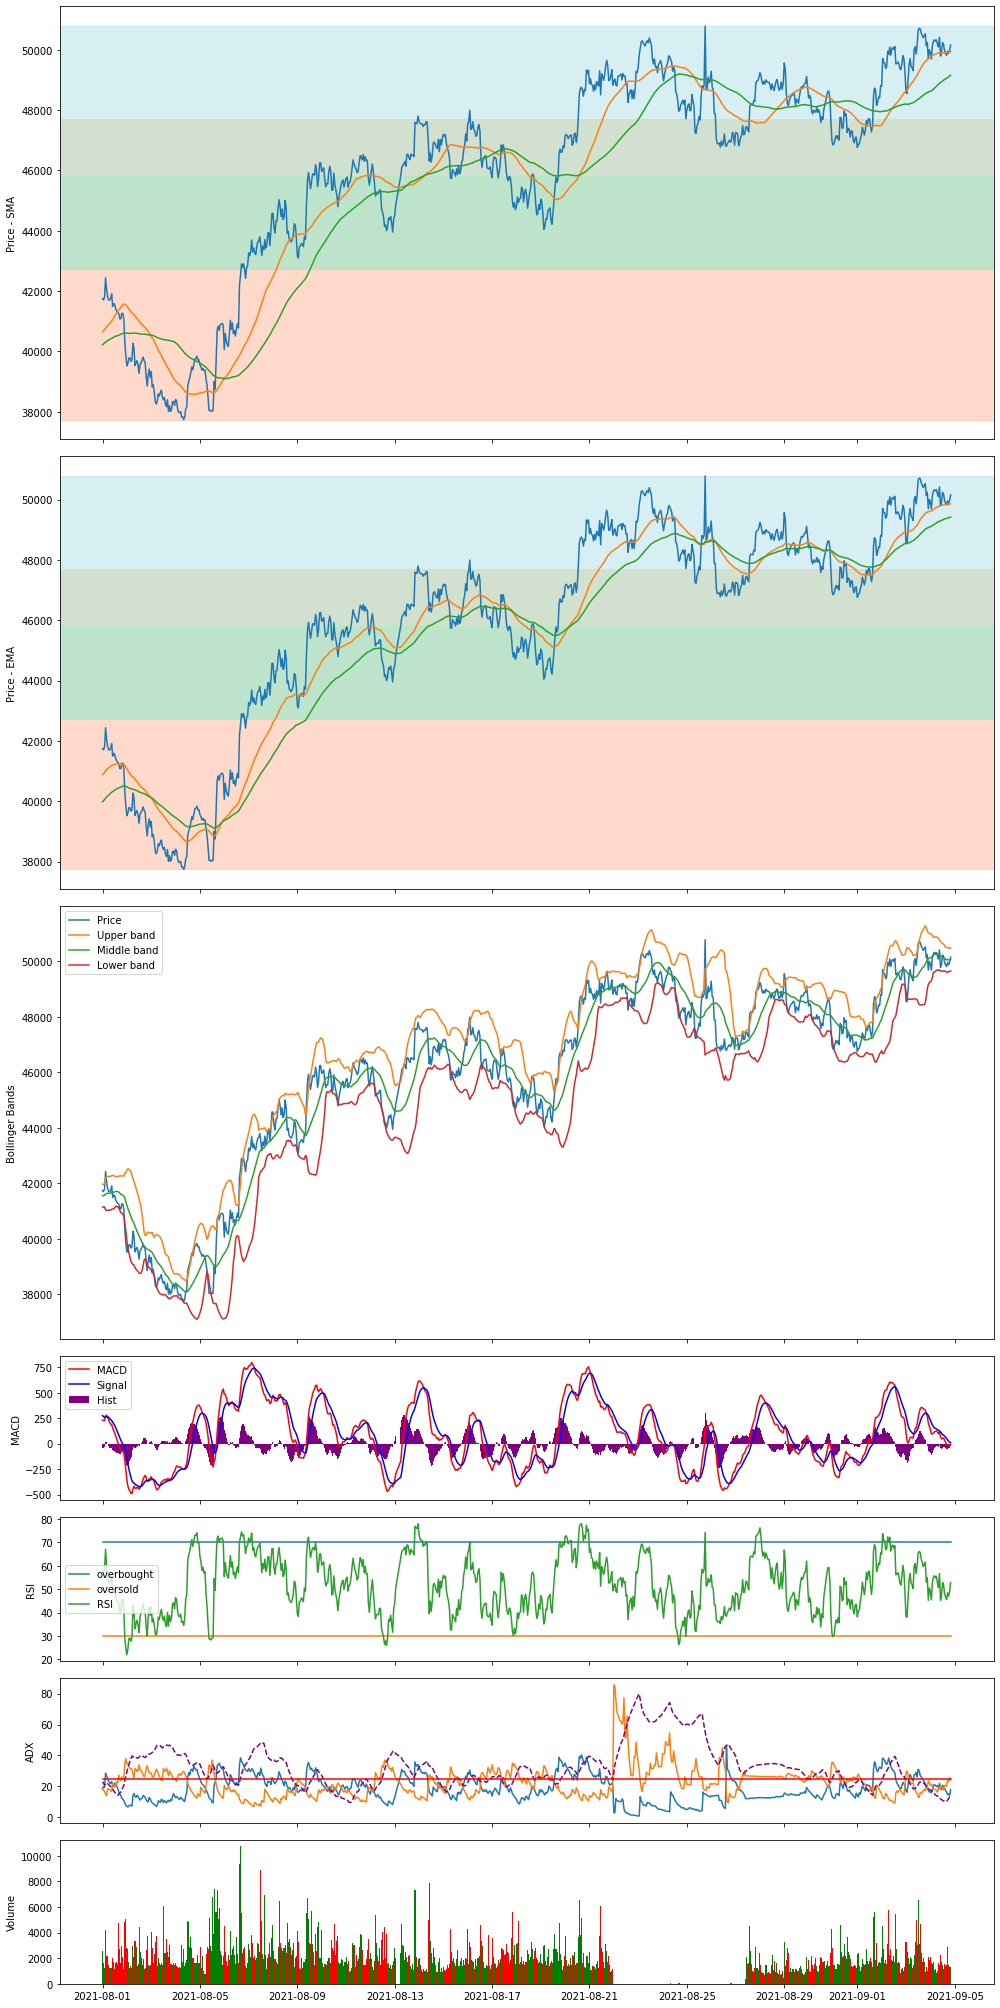

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.legend()
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.bar(data.index, data['MACDHist'], label='Hist', color="purple", width = timedelta(hours=1))
ax4.plot(data.index, data['MACDSignal'], label='Signal', color='blue')
ax4.legend()
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['RSI'], label='RSI')
ax5.legend()
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
# make bar plots and color differently depending on up/down for the day
pos = data['OpenPrice'] - data['ClosePrice'] < 0
neg = data['OpenPrice'] - data['ClosePrice'] > 0
ax7.bar(data.index[pos], data[pos]['Volume'], color='green', width = timedelta(hours=1))
ax7.bar(data.index[neg], data[neg]['Volume'], color='red', width = timedelta(hours=1))

#ax7.bar(data.index, data['Volume'] / 1000000, width = timedelta(hours=4))
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [16]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

In [17]:
from strategy_utils import get_cross_signal
from backtest_utils import signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_sma_cross = signal_strategy(price_data.copy(), signal, 'sma_cross')

In [18]:
from strategy_utils import get_cross_signal
from backtest_utils import signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_ema_cross = signal_strategy(price_data.copy(), signal, 'ema_cross')

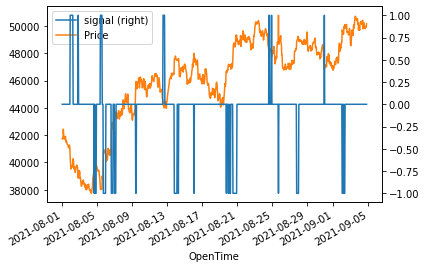

In [19]:
from strategy_utils import get_rsi_signal
from backtest_utils import signal_strategy

signal = get_rsi_signal(data[['RSI']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


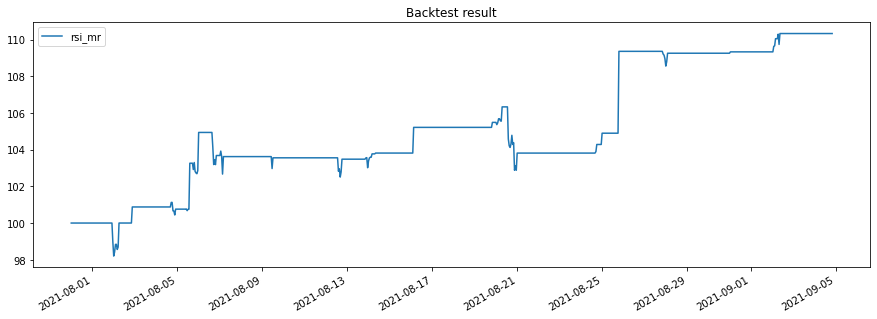

In [20]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

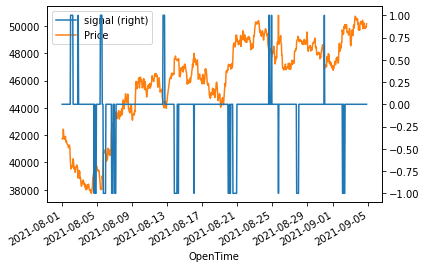

In [21]:
from strategy_utils import get_rsi_adx_signal
from backtest_utils import signal_strategy

signal = get_rsi_adx_signal(data[['RSI']].copy(), data[['ADX']])

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


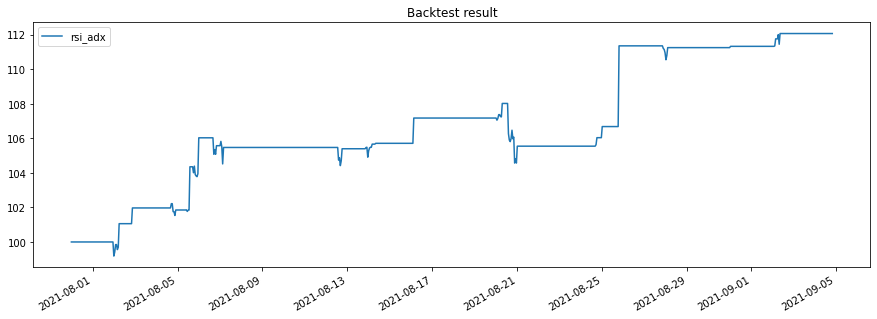

In [22]:
bt_rsi_adx = signal_strategy(price_data.copy(), signal, 'rsi_adx')

bt_result = bt.run(bt_rsi_adx)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

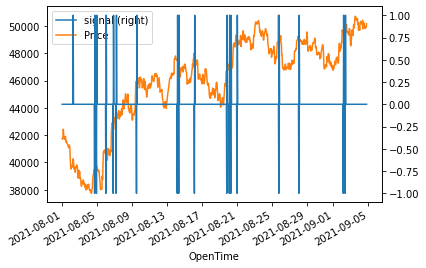

In [23]:
from strategy_utils import get_rsi_plus_signal
from backtest_utils import signal_strategy

signal = get_rsi_plus_signal(data[['RSI']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


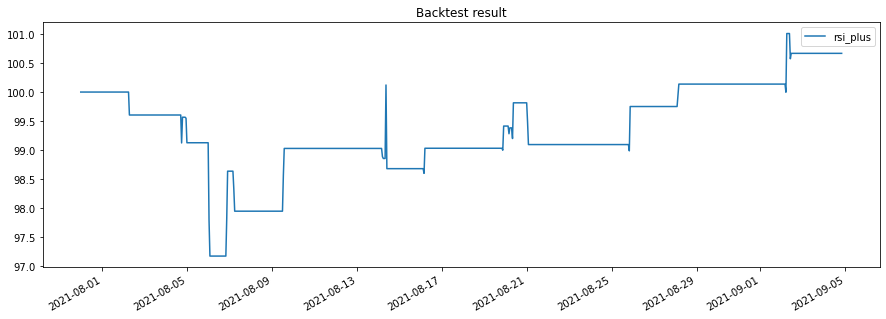

In [24]:
bt_rsi_plus = signal_strategy(price_data.copy(), signal, 'rsi_plus')

bt_result = bt.run(bt_rsi_plus)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

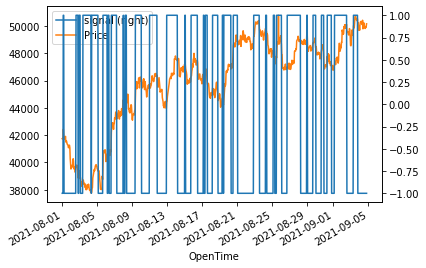

In [25]:
from strategy_utils import get_macd_signal
from backtest_utils import signal_strategy

signal = get_macd_signal(data[['MACDSignal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

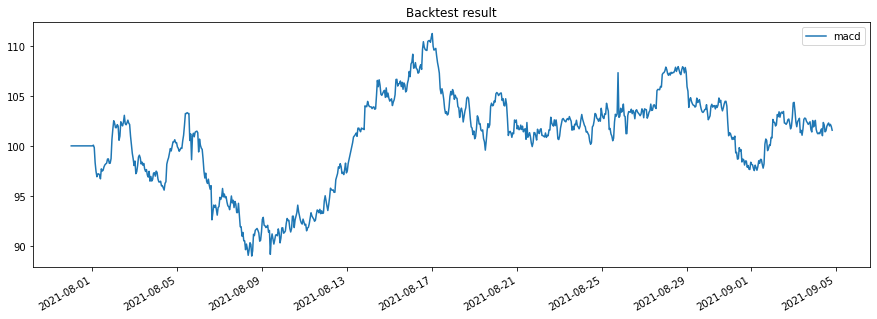

In [26]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

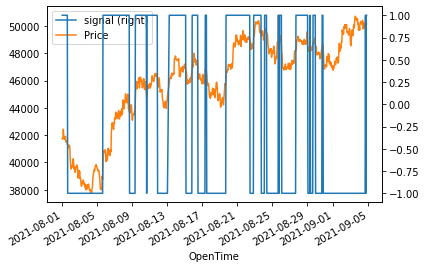

In [27]:
from strategy_utils import get_sma_macd_signal
from backtest_utils import signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

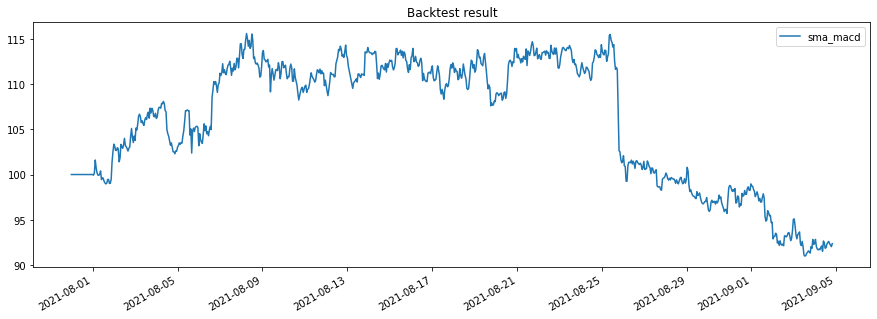

In [28]:
bt_sma_macd = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_sma_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

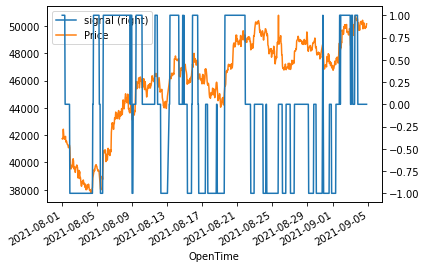

In [29]:
from strategy_utils import get_adx_macd_signal
from backtest_utils import signal_strategy

signal = get_adx_macd_signal(data[['MACD']].copy(), data[['DI+']].copy(), data[['DI-']].copy(), data[['ADX']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

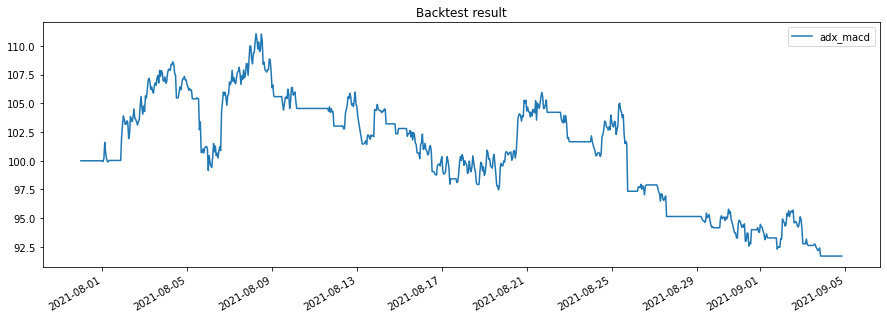

In [30]:
bt_adx_macd = signal_strategy(price_data.copy(), signal, 'adx_macd')

bt_result = bt.run(bt_adx_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [31]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma10 = signal_above_strategy(price_data.copy(), data[['SMA10']].copy(), name='SMA10')
bt_sma20 = signal_above_strategy(price_data.copy(), data[['SMA20']].copy(), name='SMA20')
bt_sma30 = signal_above_strategy(price_data.copy(), data[['SMA30']].copy(), name='SMA30')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


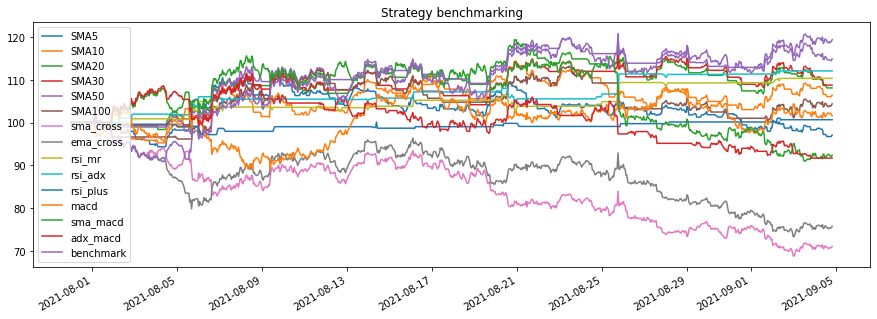

In [32]:
# Run all backtests and plot the resutls
bt_results = bt.run(bt_sma5,bt_sma10, bt_sma20, bt_sma30, bt_sma50, bt_sma100, 
                    bt_sma_cross, bt_ema_cross, bt_rsi, bt_rsi_adx, bt_rsi_plus, bt_macd, bt_sma_macd, bt_adx_macd,
                    bt_benchmark)
# Plot results
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [33]:
bt_results.display()

Stat                 SMA5        SMA10       SMA20       SMA30       SMA50       SMA100      sma_cross    ema_cross    rsi_mr      rsi_adx     rsi_plus    macd        sma_macd    adx_macd    benchmark
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  -----------  -----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2021-07-31  2021-07-31  2021-07-31  2021-07-31  2021-07-31  2021-07-31  2021-07-31   2021-07-31   2021-07-31  2021-07-31  2021-07-31  2021-07-31  2021-07-31  2021-07-31  2021-07-31
End                  2021-09-04  2021-09-04  2021-09-04  2021-09-04  2021-09-04  2021-09-04  2021-09-04   2021-09-04   2021-09-04  2021-09-04  2021-09-04  2021-09-04  2021-09-04  2021-09-04  2021-09-04
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%        0.00%        0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0

In [34]:
# Obtain all backtest stats
resInfo = bt_results.stats
ordered_strategies = resInfo.loc['total_return'].sort_values(ascending=False)
print(ordered_strategies)

best_strategy = ''
if resInfo.loc['total_return'].sort_values(ascending=False).index[0] == 'benchmark':
    best_strategy = resInfo.loc['total_return'].sort_values(ascending=False).index[1]
else:
    best_strategy = resInfo.loc['total_return'].sort_values(ascending=False).index[0]

bt_best = bt_results.backtests[best_strategy]

benchmark    0.193643
SMA50        0.148797
rsi_adx      0.120662
rsi_mr       0.103257
SMA30        0.087436
SMA20        0.080966
SMA10        0.064396
SMA100       0.043671
macd         0.015648
rsi_plus     0.006659
SMA5        -0.029243
sma_macd     -0.07645
adx_macd    -0.082995
ema_cross   -0.242626
sma_cross    -0.28949
Name: total_return, dtype: object


/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


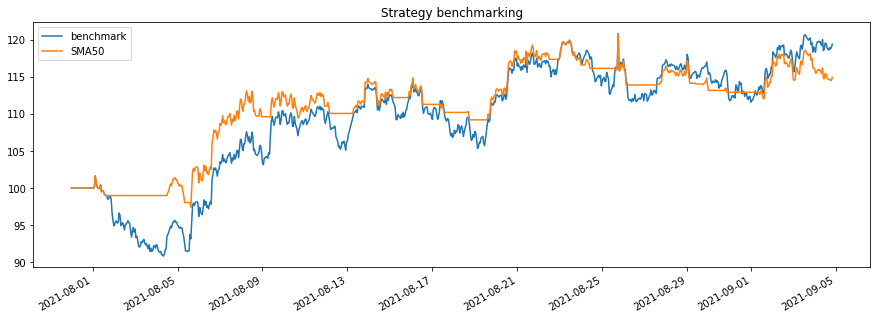

In [35]:
bt_results_best = bt.run(bt_benchmark, bt_best)
bt_results_best.plot(title='Strategy benchmarking')
plt.show()

In [36]:
bt_results_best.get_transactions(strategy_name=best_strategy)

,,price,quantity
Date,Security,,
2021-08-01 00:00:00,value,41737.37,23.0
2021-08-01 15:00:00,value,41286.98,-23.0
2021-08-04 12:00:00,value,38860.28,25.0
2021-08-05 08:00:00,value,38482.85,-25.0
2021-08-05 14:00:00,value,39002.78,25.0
2021-08-08 17:00:00,value,43674.82,-25.0
2021-08-08 20:00:00,value,43840.91,25.0
2021-08-08 23:00:00,value,43794.37,-25.0
2021-08-09 09:00:00,value,44855.11,24.0


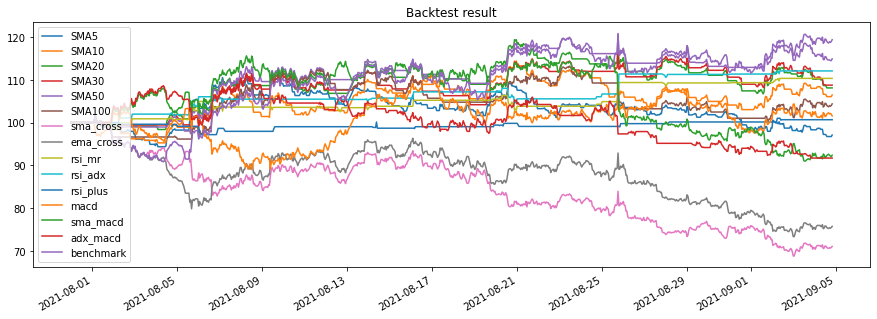

          SMA5   SMA10    SMA20    SMA30  ...    macd sma_macd adx_macd benchmark
mtd     -1.75%   3.31%    0.64%   -0.20%  ...   4.02%   -5.99%   -2.21%     6.26%
3m        nan%    nan%     nan%     nan%  ...    nan%     nan%     nan%      nan%
6m        nan%    nan%     nan%     nan%  ...    nan%     nan%     nan%      nan%
ytd     -2.92%   6.44%    8.10%    8.74%  ...   1.56%   -7.65%   -8.30%    19.36%
1y        nan%    nan%     nan%     nan%  ...    nan%     nan%     nan%      nan%
3y        nan%    nan%     nan%     nan%  ...    nan%     nan%     nan%      nan%
5y        nan%    nan%     nan%     nan%  ...    nan%     nan%     nan%      nan%
10y       nan%    nan%     nan%     nan%  ...    nan%     nan%     nan%      nan%
incep  -26.63%  91.80%  125.35%  139.83%  ...  17.59%  -56.39%  -59.51%   534.22%

[9 rows x 15 columns]


In [37]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)

# Tests

/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/Workspace/projects/cryptocurrencies-trade/.venv/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


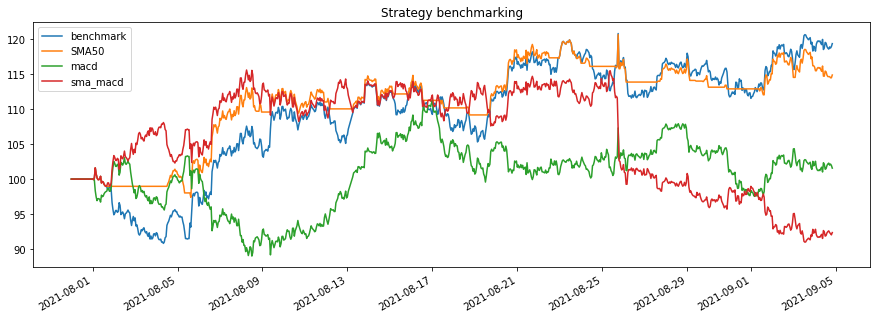

In [38]:
bt_results_test = bt.run(bt_benchmark, bt_sma50, bt_macd, bt_sma_macd)
bt_results_test.plot(title='Strategy benchmarking')
plt.show()